In [1]:
# Instalar dependencias
!pip install transformers datasets torch scikit-learn pandas numpy

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
from torch.optim import AdamW
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Cargar y preparar los datos
df = pd.read_csv('consultas_entrenamiento_modelo_mejorado.csv')

# Ver las primeras filas
print("Primeras filas del dataset:")
print(df.head())
print(f"\nTamaño del dataset: {len(df)}")

# Explorar las clases
print("\nDistribución de necesita_grafico:")
print(df['necesita_grafico'].value_counts())
print("\nDistribución de tipo_grafico:")
print(df['tipo_grafico'].value_counts())

Primeras filas del dataset:
                                            consulta necesita_grafico  \
0  Necesito mostrar gráfico la frecuencia de compras             True   
1  Obtener mostrame los transacciones por estado ...                1   
2             Sería posible transacciones por estado             True   
3  Consulta: muestrame los ventas por vendedor y ...             True   
4  Me gustaría presenta en gráfico la frecuencia ...             True   

  tipo_grafico  
0   histograma  
1       barras  
2       barras  
3       barras  
4   histograma  

Tamaño del dataset: 2500

Distribución de necesita_grafico:
necesita_grafico
True     1177
1        1145
False     139
0          39
Name: count, dtype: int64

Distribución de tipo_grafico:
tipo_grafico
barras        1362
lineal         372
circular       258
histograma     182
ninguno        178
dispersion     148
Name: count, dtype: int64


In [4]:
# Preprocesamiento de datos
def preprocess_text(text):
    """Limpia y preprocesa el texto de las consultas"""
    if isinstance(text, str):
        # Convertir a minúsculas
        text = text.lower()
        # Remover caracteres especiales pero mantener espacios y letras
        text = re.sub(r'[^\w\s]', '', text)
        return text.strip()
    return ""

In [5]:
# Aplicar preprocesamiento
df['consulta_limpia'] = df['consulta'].apply(preprocess_text)

In [6]:
# MEJORA: Procesamiento más robusto de las etiquetas
def create_improved_label(row):
    necesita_grafico = row['necesita_grafico']
    tipo_grafico = row['tipo_grafico']

    # Convertir a valores booleanos consistentes
    if necesita_grafico in [True, 'True', '1', 1, 'true']:
        necesita_grafico_bool = True
    else:
        necesita_grafico_bool = False

    # Si no necesita gráfico, siempre es 'ninguno'
    if not necesita_grafico_bool:
        return 'ninguno'

    # Si necesita gráfico pero el tipo es 'ninguno', revisar el contexto
    if tipo_grafico == 'ninguno' and necesita_grafico_bool:
        # Revisar si la consulta realmente pide un gráfico
        consulta = str(row['consulta']).lower()
        palabras_grafico = ['grafico', 'gráfico', 'chart', 'plot', 'grafica', 'gráfica', 'visualiza', 'muestra gráfico']
        if any(palabra in consulta for palabra in palabras_grafico):
            # Si la consulta menciona gráfico pero la etiqueta dice 'ninguno', usar 'barras' como default
            return 'barras'
        else:
            return 'ninguno'

    # Para los casos donde sí necesita gráfico y tiene tipo definido
    return tipo_grafico

In [7]:
# Aplicar el nuevo procesamiento de etiquetas
df['label_combinado'] = df.apply(create_improved_label, axis=1)

In [8]:
# Verificar la distribución de las nuevas etiquetas
print("\nDistribución de etiquetas combinadas MEJORADAS:")
print(df['label_combinado'].value_counts())


Distribución de etiquetas combinadas MEJORADAS:
label_combinado
barras        1362
lineal         372
circular       258
histograma     182
ninguno        178
dispersion     148
Name: count, dtype: int64


In [9]:
# Mapeo de etiquetas a números
label_mapping = {
    'ninguno': 0,
    'barras': 1,
    'histograma': 2,
    'lineal': 3,
    'circular': 4,
    'dispersion': 5
}

df['label'] = df['label_combinado'].map(label_mapping)

In [10]:
# Verificar que no hay valores nulos
print(f"\nValores nulos en labels: {df['label'].isnull().sum()}")


Valores nulos en labels: 0


In [11]:
# Mostrar algunos ejemplos para verificar
print("\nEjemplos de etiquetado:")
ejemplos_verificacion = df[['consulta', 'necesita_grafico', 'tipo_grafico', 'label_combinado']].head(10)
print(ejemplos_verificacion)



Ejemplos de etiquetado:
                                            consulta necesita_grafico  \
0  Necesito mostrar gráfico la frecuencia de compras             True   
1  Obtener mostrame los transacciones por estado ...                1   
2             Sería posible transacciones por estado             True   
3  Consulta: muestrame los ventas por vendedor y ...             True   
4  Me gustaría presenta en gráfico la frecuencia ...             True   
5  Sería posible visualiza en un gráfico los tran...             True   
6       Me gustaría clientes inactivos en el sistema             True   
7            Ventas por temporada incluyendo gráfica             True   
8                     Lista de todos los proveedores                0   
9     Mostrar ventas por temporada en gráfico lineal             True   

  tipo_grafico label_combinado  
0   histograma      histograma  
1       barras          barras  
2       barras          barras  
3       barras          barras  
4   hi

In [12]:
# Dataset personalizado
class ConsultaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [13]:
# =========================
# 5️⃣ División train / val
# =========================
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['consulta_limpia'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label'].values
)

print(f"\nTamaño del conjunto de entrenamiento: {len(train_texts)}")
print(f"Tamaño del conjunto de validación: {len(val_texts)}")


Tamaño del conjunto de entrenamiento: 2000
Tamaño del conjunto de validación: 500


In [14]:
# =========================
# CONFIGURACIÓN DE MODELOS
# =========================

# Modelo 1: DistilBERT (original)
model_name_distilbert = 'distilbert-base-uncased'
tokenizer_distilbert = DistilBertTokenizer.from_pretrained(model_name_distilbert)
num_classes = len(label_mapping)

model_distilbert = DistilBertForSequenceClassification.from_pretrained(
    model_name_distilbert,
    num_labels=num_classes
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Modelo 2: bert-base-spanish-wwm-cased
model_name_beto = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer_beto = AutoTokenizer.from_pretrained(model_name_roberta)

model_beto = AutoModelForSequenceClassification.from_pretrained(
    model_name_beto,
    num_labels=num_classes
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Configurar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_distilbert = model_distilbert.to(device)
model_beto = model_beto.to(device)
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [19]:
# =========================
# FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# =========================

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    return total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)

    return {
        'accuracy': accuracy,
        'predictions': predictions,
        'actual_labels': actual_labels,
        'loss': total_loss / len(data_loader)
    }

def train_and_evaluate_model(model, tokenizer, model_name, train_texts, train_labels, val_texts, val_labels, device):
    """Función para entrenar y evaluar un modelo específico"""
    print(f"\n{'='*60}")
    print(f"ENTRENANDO: {model_name}")
    print(f"{'='*60}")

    # Crear datasets y dataloaders específicos para este modelo
    train_dataset = ConsultaDataset(train_texts, train_labels, tokenizer)
    val_dataset = ConsultaDataset(val_texts, val_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Configurar optimizador y scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    total_steps = len(train_loader) * 4
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Entrenamiento
    best_accuracy = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(4):
        print(f'\nÉpoca {epoch + 1}/4')

        # Entrenamiento
        train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
        train_losses.append(train_loss)

        # Evaluación
        eval_results = eval_model(model, val_loader, device)
        val_accuracies.append(eval_results['accuracy'])

        print(f'Pérdida de entrenamiento: {train_loss:.4f}')
        print(f'Precisión en validación: {eval_results["accuracy"]:.4f}')
        print(f'Pérdida en validación: {eval_results["loss"]:.4f}')

        # Guardar el mejor modelo
        if eval_results['accuracy'] > best_accuracy:
            best_accuracy = eval_results['accuracy']
            torch.save(model.state_dict(), f'mejor_modelo_{model_name.replace("/", "_")}.pth')
            print("¡Nuevo mejor modelo guardado!")

    # Evaluación final
    final_results = eval_model(model, val_loader, device)

    return {
        'model': model,
        'tokenizer': tokenizer,
        'final_accuracy': final_results['accuracy'],
        'predictions': final_results['predictions'],
        'actual_labels': final_results['actual_labels'],
        'train_losses': train_losses,
        'val_accuracies': val_accuracies
    }

# =========================
# VALIDACIÓN CRUZADA CON K-FOLD
# =========================

def ejecutar_validacion_cruzada(model_class, tokenizer, model_name, texts, labels, device,
                               n_splits=5, epochs=3, batch_size=16):
    """
    Ejecuta validación cruzada k-fold para un modelo específico
    """
    print(f"\n{'='*60}")
    print(f"VALIDACIÓN CRUZADA {n_splits}-FOLD: {model_name}")
    print(f"{'='*60}")

    # Configurar k-fold
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Almacenar resultados
    fold_results = {
        'accuracies': [],
        'losses': [],
        'predictions': [],
        'actual_labels': [],
        'fold_models': []
    }

    fold_num = 1

    for train_idx, val_idx in kf.split(texts, labels):
        print(f"\n🎯 Fold {fold_num}/{n_splits}")

        # Dividir datos
        train_texts_fold = texts[train_idx]
        train_labels_fold = labels[train_idx]
        val_texts_fold = texts[val_idx]
        val_labels_fold = labels[val_idx]

        print(f"   Training: {len(train_texts_fold)} samples")
        print(f"   Validation: {len(val_texts_fold)} samples")

        # Crear datasets
        train_dataset = ConsultaDataset(train_texts_fold, train_labels_fold, tokenizer)
        val_dataset = ConsultaDataset(val_texts_fold, val_labels_fold, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Inicializar modelo para este fold
        model = model_class.from_pretrained(
            model_name if isinstance(model_class, type) else model_name,
            num_labels=len(label_mapping)
        )
        model.to(device)

        # Optimizador y scheduler
        optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Entrenar modelo para este fold
        best_fold_accuracy = 0

        for epoch in range(epochs):
            print(f'   Época {epoch + 1}/{epochs}', end=' - ')

            # Entrenamiento
            train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)

            # Evaluación
            eval_results = eval_model(model, val_loader, device)

            print(f'Val Accuracy: {eval_results["accuracy"]:.4f}, Loss: {eval_results["loss"]:.4f}')

            if eval_results['accuracy'] > best_fold_accuracy:
                best_fold_accuracy = eval_results['accuracy']

        # Guardar resultados del fold
        fold_results['accuracies'].append(best_fold_accuracy)
        fold_results['losses'].append(eval_results['loss'])
        fold_results['predictions'].extend(eval_results['predictions'])
        fold_results['actual_labels'].extend(eval_results['actual_labels'])
        fold_results['fold_models'].append(model.state_dict().copy())

        print(f"   ✅ Fold {fold_num} completado - Mejor Accuracy: {best_fold_accuracy:.4f}")
        fold_num += 1

    return fold_results

In [21]:
# =========================
# EJECUTAR VALIDACIÓN CRUZADA PARA AMBOS MODELOS
# =========================

print(f"\n{'='*60}")
print("INICIANDO VALIDACIÓN CRUZADA COMPARATIVA")
print(f"{'='*60}")

# Ejecutar validación cruzada para DistilBERT
cv_results_distilbert = ejecutar_validacion_cruzada(
    DistilBertForSequenceClassification,
    tokenizer_distilbert,
    'distilbert-base-uncased',
    df['consulta_limpia'].values,
    df['label'].values,
    device,
    n_splits=5,
    epochs=3,
    batch_size=16
)

# Ejecutar validación cruzada para bert-base-spanish-wwm-cased
cv_results_beto = ejecutar_validacion_cruzada(
    AutoModelForSequenceClassification,
    tokenizer_beto,
    'dccuchile/bert-base-spanish-wwm-cased',
    df['consulta_limpia'].values,
    df['label'].values,
    device,
    n_splits=5,
    epochs=3,
    batch_size=16
)



INICIANDO VALIDACIÓN CRUZADA COMPARATIVA

VALIDACIÓN CRUZADA 5-FOLD: distilbert-base-uncased

🎯 Fold 1/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.7200, Loss: 0.9544
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8180, Loss: 0.6890
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8340, Loss: 0.6463
   ✅ Fold 1 completado - Mejor Accuracy: 0.8340

🎯 Fold 2/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.7920, Loss: 0.8625
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8320, Loss: 0.6174
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8300, Loss: 0.5806
   ✅ Fold 2 completado - Mejor Accuracy: 0.8320

🎯 Fold 3/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8200, Loss: 0.8323
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8600, Loss: 0.5960
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8600, Loss: 0.5649
   ✅ Fold 3 completado - Mejor Accuracy: 0.8600

🎯 Fold 4/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8080, Loss: 0.8463
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8540, Loss: 0.6016
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8600, Loss: 0.5492
   ✅ Fold 4 completado - Mejor Accuracy: 0.8600

🎯 Fold 5/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.7920, Loss: 0.8544
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8440, Loss: 0.6302
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8360, Loss: 0.6214
   ✅ Fold 5 completado - Mejor Accuracy: 0.8440

VALIDACIÓN CRUZADA 5-FOLD: dccuchile/bert-base-spanish-wwm-cased

🎯 Fold 1/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8220, Loss: 0.6751
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8480, Loss: 0.5874
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8380, Loss: 0.5485
   ✅ Fold 1 completado - Mejor Accuracy: 0.8480

🎯 Fold 2/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8300, Loss: 0.6124
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8300, Loss: 0.5297
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8360, Loss: 0.4918
   ✅ Fold 2 completado - Mejor Accuracy: 0.8360

🎯 Fold 3/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8440, Loss: 0.6176
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8540, Loss: 0.4692
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8340, Loss: 0.4621
   ✅ Fold 3 completado - Mejor Accuracy: 0.8540

🎯 Fold 4/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8500, Loss: 0.5352
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8500, Loss: 0.4607
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8580, Loss: 0.4342
   ✅ Fold 4 completado - Mejor Accuracy: 0.8580

🎯 Fold 5/5
   Training: 2000 samples
   Validation: 500 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Época 1/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8180, Loss: 0.6404
   Época 2/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8300, Loss: 0.4563
   Época 3/3 - 

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Val Accuracy: 0.8300, Loss: 0.4446
   ✅ Fold 5 completado - Mejor Accuracy: 0.8300


In [22]:
# =========================
# ANÁLISIS DE RESULTADOS DE VALIDACIÓN CRUZADA
# =========================

print(f"\n{'='*60}")
print("RESULTADOS DE VALIDACIÓN CRUZADA")
print(f"{'='*60}")

# Métricas de validación cruzada
cv_comparison = {
    'Modelo': ['DistilBERT', 'Beto'],
    'Accuracy Promedio': [
        np.mean(cv_results_distilbert['accuracies']),
        np.mean(cv_results_beto['accuracies'])
    ],
    'Desviación Estándar': [
        np.std(cv_results_distilbert['accuracies']),
        np.std(cv_results_beto['accuracies'])
    ],
    'Accuracy Mínimo': [
        np.min(cv_results_distilbert['accuracies']),
        np.min(cv_results_beto['accuracies'])
    ],
    'Accuracy Máximo': [
        np.max(cv_results_distilbert['accuracies']),
        np.max(cv_results_beto['accuracies'])
    ]
}

cv_comparison_df = pd.DataFrame(cv_comparison)
print("\n📊 Resultados de Validación Cruzada (5-Fold):")
print(cv_comparison_df)

# Mostrar resultados por fold
print(f"\n{'─'*50}")
print("RESULTADOS POR FOLD")
print(f"{'─'*50}")

print(f"\nDistilBERT:")
for i, acc in enumerate(cv_results_distilbert['accuracies'], 1):
    print(f"  Fold {i}: {acc:.4f}")

print(f"\nbert-base-spanish:")
for i, acc in enumerate(cv_results_beto['accuracies'], 1):
    print(f"  Fold {i}: {acc:.4f}")


RESULTADOS DE VALIDACIÓN CRUZADA

📊 Resultados de Validación Cruzada (5-Fold):
       Modelo  Accuracy Promedio  Desviación Estándar  Accuracy Mínimo  \
0  DistilBERT             0.8460             0.012133            0.832   
1        Beto             0.8452             0.010628            0.830   

   Accuracy Máximo  
0            0.860  
1            0.858  

──────────────────────────────────────────────────
RESULTADOS POR FOLD
──────────────────────────────────────────────────

DistilBERT:
  Fold 1: 0.8340
  Fold 2: 0.8320
  Fold 3: 0.8600
  Fold 4: 0.8600
  Fold 5: 0.8440

bert-base-spanish:
  Fold 1: 0.8480
  Fold 2: 0.8360
  Fold 3: 0.8540
  Fold 4: 0.8580
  Fold 5: 0.8300


In [23]:
# Mapeo inverso para los nombres de las clases
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
class_names = [reverse_label_mapping[i] for i in range(num_classes)]

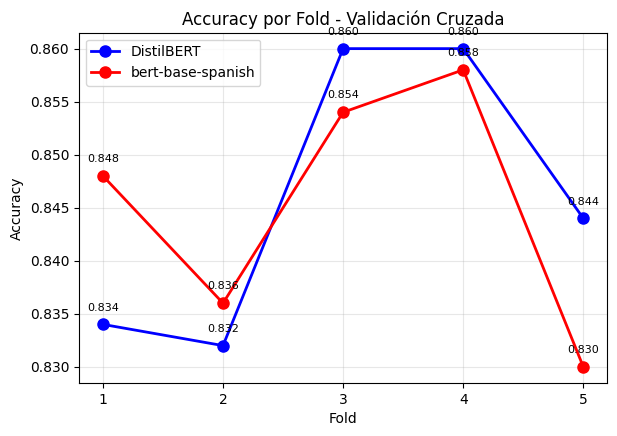

In [24]:
# =========================
# GRÁFICAS DE VALIDACIÓN CRUZADA
# =========================

plt.figure(figsize=(15, 10))

# Gráfica 1: Comparación de accuracy por fold
plt.subplot(2, 2, 1)
folds = range(1, 6)
plt.plot(folds, cv_results_distilbert['accuracies'], 'bo-', label='DistilBERT', linewidth=2, markersize=8)
plt.plot(folds, cv_results_beto['accuracies'], 'ro-', label='bert-base-spanish', linewidth=2, markersize=8)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy por Fold - Validación Cruzada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(folds)

# Añadir valores en los puntos
for i, (acc_d, acc_r) in enumerate(zip(cv_results_distilbert['accuracies'], cv_results_beto['accuracies'])):
    plt.annotate(f'{acc_d:.3f}', (i+1, acc_d), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    plt.annotate(f'{acc_r:.3f}', (i+1, acc_r), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

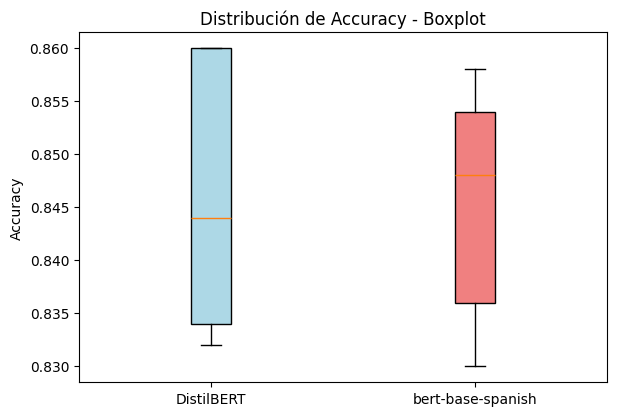

In [25]:
# Gráfica 2: Boxplot de comparación
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
data = [cv_results_distilbert['accuracies'], cv_results_beto['accuracies']]
box = plt.boxplot(data, labels=['DistilBERT', 'bert-base-spanish'], patch_artist=True)
plt.ylabel('Accuracy')
plt.title('Distribución de Accuracy - Boxplot')

# Colorear los boxplots
colors = ['lightblue', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

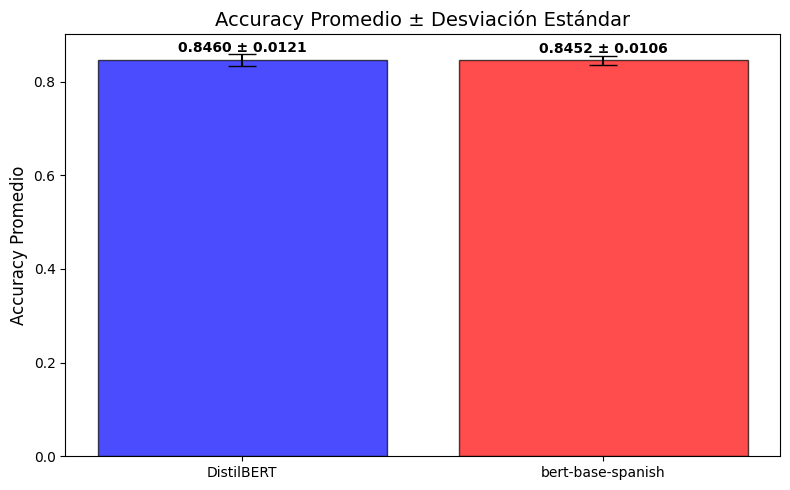

In [30]:
# Gráfica 3: Barras con promedio y desviación estándar
plt.figure(figsize=(8, 5))

models = ['DistilBERT', 'bert-base-spanish']
means = [cv_comparison['Accuracy Promedio'][0], cv_comparison['Accuracy Promedio'][1]]
stds = [cv_comparison['Desviación Estándar'][0], cv_comparison['Desviación Estándar'][1]]

bars = plt.bar(models, means, yerr=stds, capsize=10, alpha=0.7,
               color=['blue', 'red'], edgecolor='black')
plt.ylabel('Accuracy Promedio', fontsize=12)
plt.title('Accuracy Promedio ± Desviación Estándar', fontsize=14)

# Añadir valores en las barras
for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{mean:.4f} ± {std:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('validacion_cruzada_resultados.png', dpi=300, bbox_inches='tight')
plt.show()

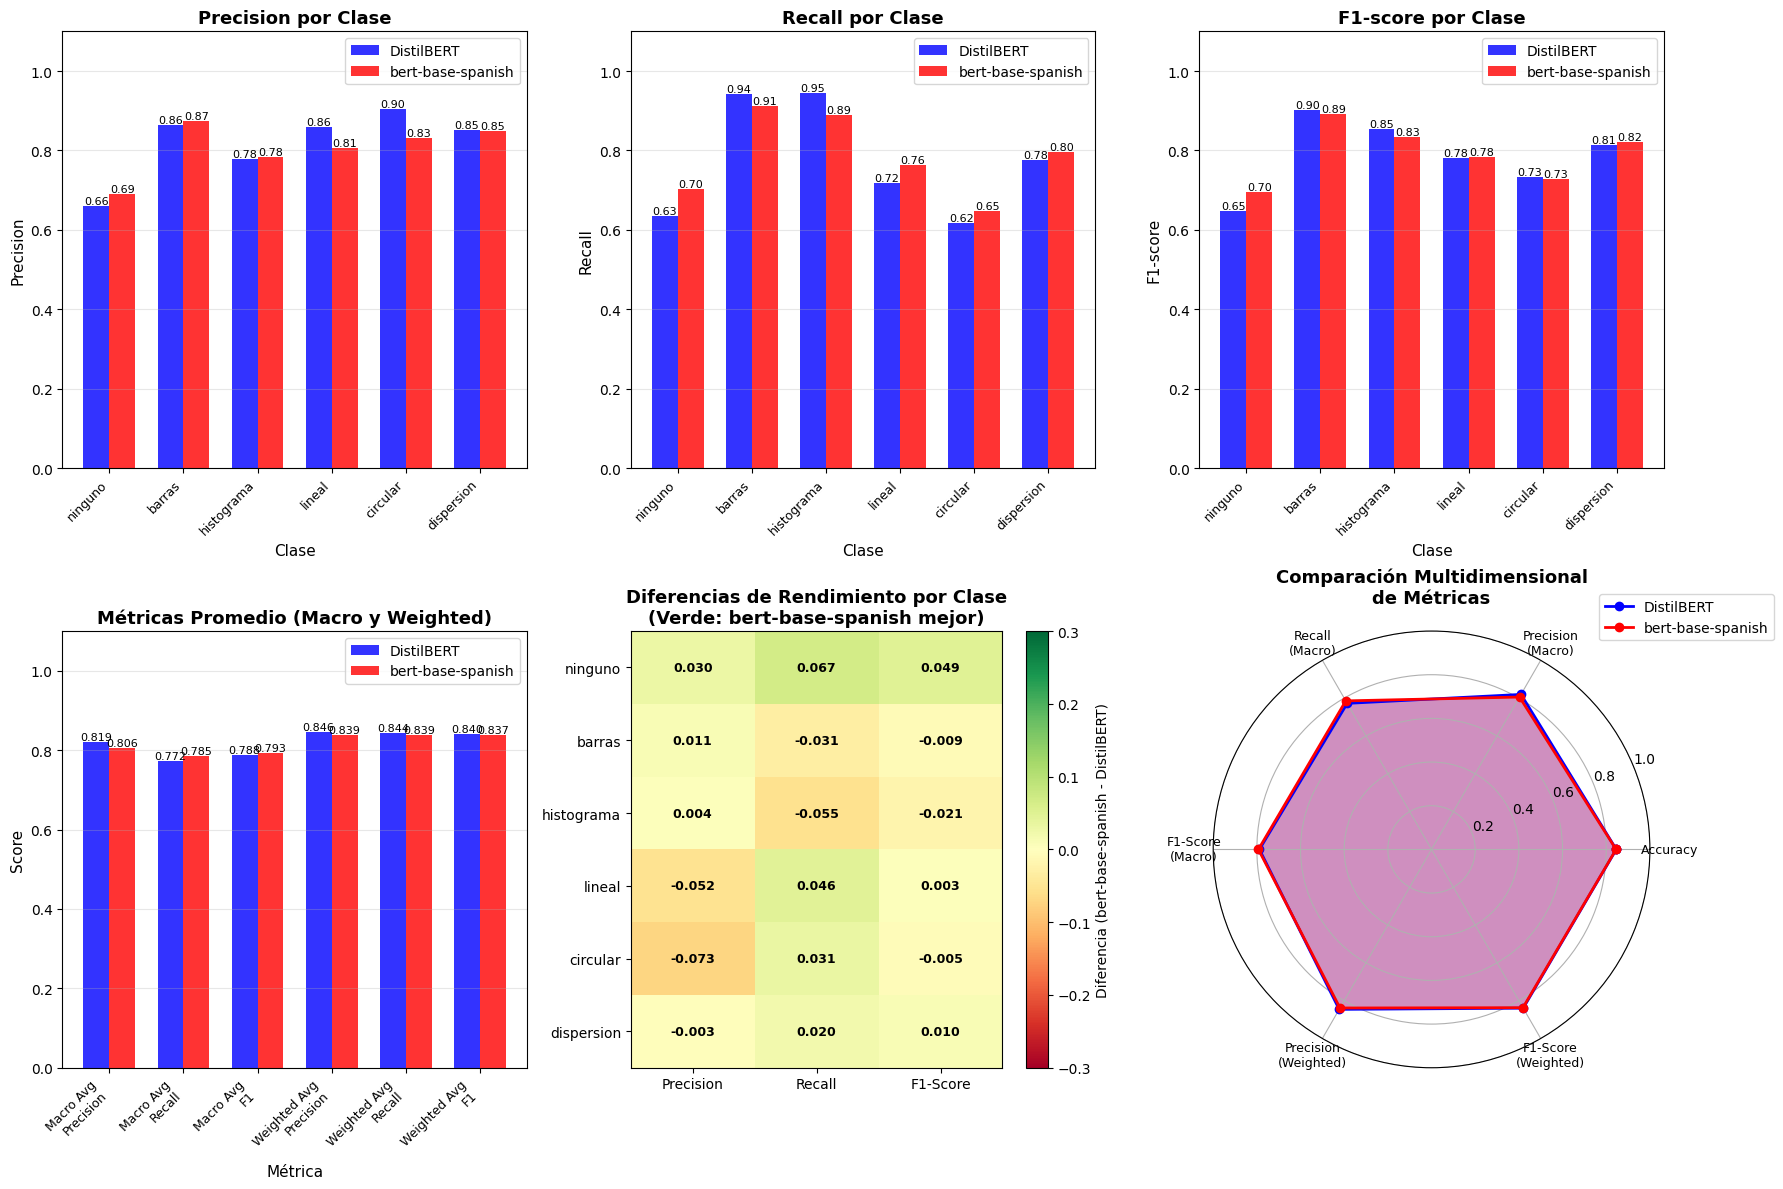

In [31]:
plt.figure(figsize=(18, 12))

# Gráfica 5: Precision, Recall y F1-Score por clase
plt.subplot(2, 3, 1)
# Calcular métricas por clase para ambos modelos

report_distilbert = classification_report(cv_results_distilbert['actual_labels'],
                                          cv_results_distilbert['predictions'],
                                          target_names=class_names,
                                          output_dict=True)
report_beto = classification_report(cv_results_beto['actual_labels'],
                                      cv_results_beto['predictions'],
                                      target_names=class_names,
                                      output_dict=True)

# Extraer métricas
metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(class_names))
width = 0.35

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    values_distilbert = [report_distilbert[cls][metric] for cls in class_names]
    values_beto = [report_beto[cls][metric] for cls in class_names]

    bars1 = plt.bar(x - width/2, values_distilbert, width, label='DistilBERT',
                    alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, values_beto, width, label='bert-base-spanish',
                    alpha=0.8, color='red')

    plt.xlabel('Clase', fontsize=11)
    plt.ylabel(metric.capitalize(), fontsize=11)
    plt.title(f'{metric.capitalize()} por Clase', fontsize=13, fontweight='bold')
    plt.xticks(x, class_names, rotation=45, ha='right', fontsize=9)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.ylim([0, 1.1])

    # Añadir valores en las barras
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# Gráfica 6: Comparación de Macro y Weighted Average
plt.subplot(2, 3, 4)
categories = ['Macro Avg\nPrecision', 'Macro Avg\nRecall', 'Macro Avg\nF1',
              'Weighted Avg\nPrecision', 'Weighted Avg\nRecall', 'Weighted Avg\nF1']
distilbert_values = [
    report_distilbert['macro avg']['precision'],
    report_distilbert['macro avg']['recall'],
    report_distilbert['macro avg']['f1-score'],
    report_distilbert['weighted avg']['precision'],
    report_distilbert['weighted avg']['recall'],
    report_distilbert['weighted avg']['f1-score']
]
roberta_values = [
    report_beto['macro avg']['precision'],
    report_beto['macro avg']['recall'],
    report_beto['macro avg']['f1-score'],
    report_beto['weighted avg']['precision'],
    report_beto['weighted avg']['recall'],
    report_beto['weighted avg']['f1-score']
]

x = np.arange(len(categories))
width = 0.35
bars1 = plt.bar(x - width/2, distilbert_values, width, label='DistilBERT',
                alpha=0.8, color='blue')
bars2 = plt.bar(x + width/2, roberta_values, width, label='bert-base-spanish',
                alpha=0.8, color='red')

plt.xlabel('Métrica', fontsize=11)
plt.ylabel('Score', fontsize=11)
plt.title('Métricas Promedio (Macro y Weighted)', fontsize=13, fontweight='bold')
plt.xticks(x, categories, rotation=45, ha='right', fontsize=9)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([0, 1.1])

# Añadir valores
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Gráfica 7: Heatmap de diferencias entre modelos
plt.subplot(2, 3, 5)
metrics_names = ['Precision', 'Recall', 'F1-Score']
differences = np.zeros((len(class_names), len(metrics_names)))

for i, cls in enumerate(class_names):
    for j, metric in enumerate(['precision', 'recall', 'f1-score']):
        diff = report_beto[cls][metric] - report_distilbert[cls][metric]
        differences[i, j] = diff

im = plt.imshow(differences, cmap='RdYlGn', aspect='auto', vmin=-0.3, vmax=0.3)
plt.colorbar(im, label='Diferencia (bert-base-spanish - DistilBERT)')
plt.xticks(range(len(metrics_names)), metrics_names, fontsize=10)
plt.yticks(range(len(class_names)), class_names, fontsize=10)
plt.title('Diferencias de Rendimiento por Clase\n(Verde: bert-base-spanish mejor)',
         fontsize=13, fontweight='bold')

# Añadir valores en las celdas
for i in range(len(class_names)):
    for j in range(len(metrics_names)):
        text = plt.text(j, i, f'{differences[i, j]:.3f}',
                       ha="center", va="center",
                       color="black" if abs(differences[i, j]) < 0.15 else "white",
                       fontsize=9, fontweight='bold')

# Gráfica 8: Radar chart comparativo
plt.subplot(2, 3, 6, projection='polar')
categories_radar = ['Accuracy', 'Precision\n(Macro)', 'Recall\n(Macro)',
                    'F1-Score\n(Macro)', 'Precision\n(Weighted)', 'F1-Score\n(Weighted)']
N = len(categories_radar)

values_distilbert_radar = [
    np.mean(cv_results_distilbert['accuracies']),
    report_distilbert['macro avg']['precision'],
    report_distilbert['macro avg']['recall'],
    report_distilbert['macro avg']['f1-score'],
    report_distilbert['weighted avg']['precision'],
    report_distilbert['weighted avg']['f1-score']
]

values_beto_radar = [
    np.mean(cv_results_beto['accuracies']),
    report_beto['macro avg']['precision'],
    report_beto['macro avg']['recall'],
    report_beto['macro avg']['f1-score'],
    report_beto['weighted avg']['precision'],
    report_beto['weighted avg']['f1-score']
]

angles = [n / float(N) * 2 * np.pi for n in range(N)]
values_distilbert_radar += values_distilbert_radar[:1]
values_beto_radar += values_beto_radar[:1]
angles += angles[:1]

ax = plt.subplot(2, 3, 6, projection='polar')
ax.plot(angles, values_distilbert_radar, 'o-', linewidth=2, label='DistilBERT', color='blue')
ax.fill(angles, values_distilbert_radar, alpha=0.25, color='blue')
ax.plot(angles, values_beto_radar, 'o-', linewidth=2, label='bert-base-spanish', color='red')
ax.fill(angles, values_beto_radar, alpha=0.25, color='red')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories_radar, fontsize=9)
ax.set_ylim(0, 1)
ax.set_title('Comparación Multidimensional\nde Métricas',
            fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig('comparacion_metricas_adicionales.png', dpi=300, bbox_inches='tight')
plt.show()

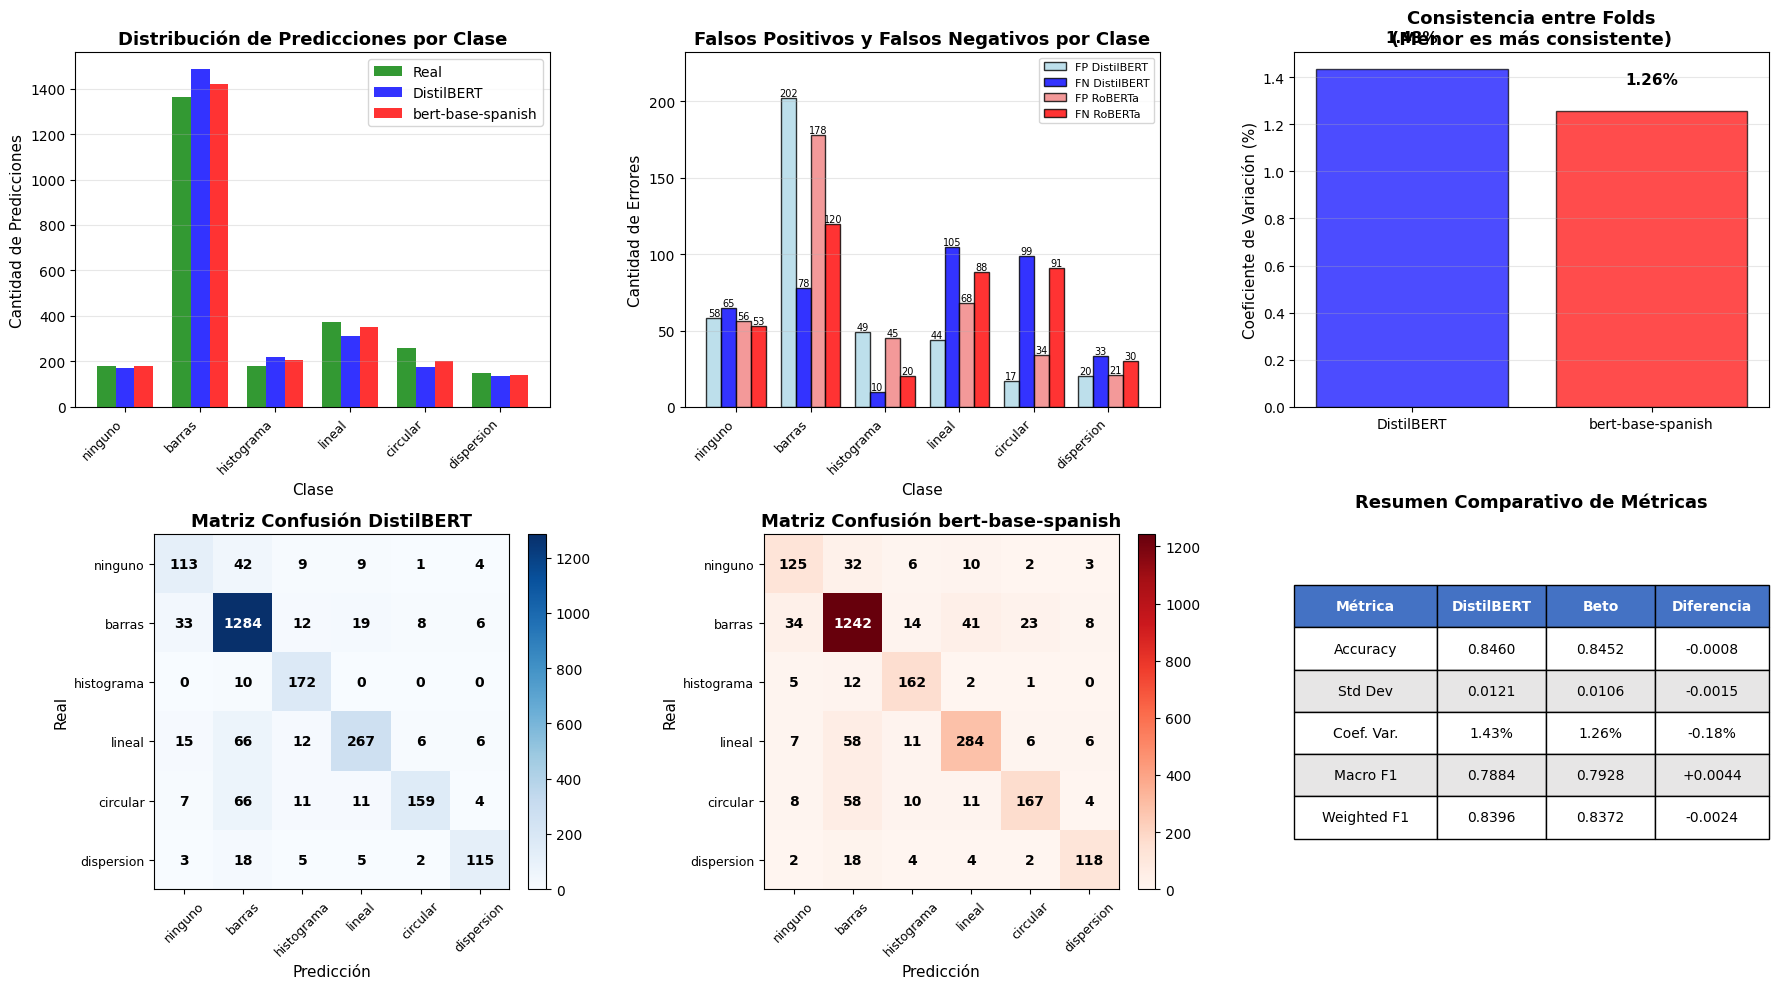


✅ Gráfica de análisis de errores y consistencia generada exitosamente!


In [36]:
# =========================
# FIGURA 3: Análisis de errores y consistencia
# =========================

plt.figure(figsize=(18, 10))

# Gráfica 9: Distribución de clases predichas vs reales
plt.subplot(2, 3, 1)
from collections import Counter
real_counts = Counter(cv_results_distilbert['actual_labels'])
pred_distilbert_counts = Counter(cv_results_distilbert['predictions'])
pred_beto_counts = Counter(cv_results_beto['predictions'])
cm_cv_distilbert = confusion_matrix(cv_results_distilbert['actual_labels'],
                                   cv_results_distilbert['predictions'])
cm_cv_beto = confusion_matrix(cv_results_beto['actual_labels'],
                                cv_results_beto['predictions'])

x = np.arange(len(class_names))
width = 0.25

bars1 = plt.bar(x - width, [real_counts[i] for i in range(len(class_names))],
                width, label='Real', alpha=0.8, color='green')
bars2 = plt.bar(x, [pred_distilbert_counts[i] for i in range(len(class_names))],
                width, label='DistilBERT', alpha=0.8, color='blue')
bars3 = plt.bar(x + width, [pred_beto_counts[i] for i in range(len(class_names))],
                width, label='bert-base-spanish', alpha=0.8, color='red')

plt.xlabel('Clase', fontsize=11)
plt.ylabel('Cantidad de Predicciones', fontsize=11)
plt.title('Distribución de Predicciones por Clase', fontsize=13, fontweight='bold')
plt.xticks(x, class_names, rotation=45, ha='right', fontsize=9)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Gráfica 10: Errores por clase (False Positives y False Negatives) - CORREGIDO
plt.subplot(2, 3, 2)

# Convertir a arrays de numpy si no lo son ya
actual_distilbert = np.array(cv_results_distilbert['actual_labels'])
pred_distilbert = np.array(cv_results_distilbert['predictions'])
actual_roberta = np.array(cv_results_beto['actual_labels'])
pred_roberta = np.array(cv_results_beto['predictions'])

fp_distilbert = []
fn_distilbert = []
fp_roberta = []
fn_roberta = []

for i in range(len(class_names)):
    # DistilBERT - Falsos Positivos: predijo clase i pero no era i
    fp_d = int(np.sum((pred_distilbert == i) & (actual_distilbert != i)))
    fp_distilbert.append(fp_d)

    # DistilBERT - Falsos Negativos: era clase i pero no predijo i
    fn_d = int(np.sum((pred_distilbert != i) & (actual_distilbert == i)))
    fn_distilbert.append(fn_d)

    # RoBERTa - Falsos Positivos
    fp_r = int(np.sum((pred_roberta == i) & (actual_roberta != i)))
    fp_roberta.append(fp_r)

    # RoBERTa - Falsos Negativos
    fn_r = int(np.sum((pred_roberta != i) & (actual_roberta == i)))
    fn_roberta.append(fn_r)

x = np.arange(len(class_names))
width = 0.2

bars1 = plt.bar(x - 1.5*width, fp_distilbert, width, label='FP DistilBERT',
                alpha=0.8, color='lightblue', edgecolor='black')
bars2 = plt.bar(x - 0.5*width, fn_distilbert, width, label='FN DistilBERT',
                alpha=0.8, color='blue', edgecolor='black')
bars3 = plt.bar(x + 0.5*width, fp_roberta, width, label='FP RoBERTa',
                alpha=0.8, color='lightcoral', edgecolor='black')
bars4 = plt.bar(x + 1.5*width, fn_roberta, width, label='FN RoBERTa',
                alpha=0.8, color='red', edgecolor='black')

plt.xlabel('Clase', fontsize=11)
plt.ylabel('Cantidad de Errores', fontsize=11)
plt.title('Falsos Positivos y Falsos Negativos por Clase', fontsize=13, fontweight='bold')
plt.xticks(x, class_names, rotation=45, ha='right', fontsize=9)
plt.legend(fontsize=8, loc='upper right')
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras si son mayores a 0
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=7)

# Ajustar límite y del gráfico
max_error = max(max(fp_distilbert) if fp_distilbert else 0,
                max(fn_distilbert) if fn_distilbert else 0,
                max(fp_roberta) if fp_roberta else 0,
                max(fn_roberta) if fn_roberta else 0)
if max_error > 0:
    plt.ylim([0, max_error * 1.15])

# Gráfica 11: Consistencia entre folds (variabilidad)
plt.subplot(2, 3, 3)
cv_distilbert = np.array(cv_results_distilbert['accuracies'])
cv_roberta = np.array(cv_results_beto['accuracies'])
coef_var_distilbert = (np.std(cv_distilbert) / np.mean(cv_distilbert)) * 100
coef_var_roberta = (np.std(cv_roberta) / np.mean(cv_roberta)) * 100

models = ['DistilBERT', 'bert-base-spanish']
coef_vars = [coef_var_distilbert, coef_var_roberta]
colors = ['blue', 'red']

bars = plt.bar(models, coef_vars, alpha=0.7, color=colors, edgecolor='black')
plt.ylabel('Coeficiente de Variación (%)', fontsize=11)
plt.title('Consistencia entre Folds\n(Menor es más consistente)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

for bar, cv in zip(bars, coef_vars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{cv:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Gráfica 12: Matriz de confusión lado a lado
plt.subplot(2, 3, 4)
im1 = plt.imshow(cm_cv_distilbert, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz Confusión DistilBERT', fontsize=13, fontweight='bold')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, fontsize=9)
plt.yticks(np.arange(len(class_names)), class_names, fontsize=9)
plt.xlabel('Predicción', fontsize=11)
plt.ylabel('Real', fontsize=11)

thresh = cm_cv_distilbert.max() / 2.
for i in range(cm_cv_distilbert.shape[0]):
    for j in range(cm_cv_distilbert.shape[1]):
        plt.text(j, i, format(cm_cv_distilbert[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_cv_distilbert[i, j] > thresh else "black",
                fontweight='bold', fontsize=10)
plt.colorbar(im1, fraction=0.046, pad=0.04)

plt.subplot(2, 3, 5)
im2 = plt.imshow(cm_cv_beto, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Matriz Confusión bert-base-spanish', fontsize=13, fontweight='bold')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, fontsize=9)
plt.yticks(np.arange(len(class_names)), class_names, fontsize=9)
plt.xlabel('Predicción', fontsize=11)
plt.ylabel('Real', fontsize=11)

thresh = cm_cv_beto.max() / 2.
for i in range(cm_cv_beto.shape[0]):
    for j in range(cm_cv_beto.shape[1]):
        plt.text(j, i, format(cm_cv_beto[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_cv_beto[i, j] > thresh else "black",
                fontweight='bold', fontsize=10)
plt.colorbar(im2, fraction=0.046, pad=0.04)

# Gráfica 13: Tabla resumen de métricas clave
plt.subplot(2, 3, 6)
plt.axis('off')

summary_data = [
    ['Métrica', 'DistilBERT', 'Beto', 'Diferencia'],
    ['Accuracy', f"{means[0]:.4f}", f"{means[1]:.4f}", f"{means[1]-means[0]:+.4f}"],
    ['Std Dev', f"{stds[0]:.4f}", f"{stds[1]:.4f}", f"{stds[1]-stds[0]:+.4f}"],
    ['Coef. Var.', f"{coef_var_distilbert:.2f}%", f"{coef_var_roberta:.2f}%",
     f"{coef_var_roberta-coef_var_distilbert:+.2f}%"],
    ['Macro F1', f"{report_distilbert['macro avg']['f1-score']:.4f}",
     f"{report_beto['macro avg']['f1-score']:.4f}",
     f"{report_beto['macro avg']['f1-score']-report_distilbert['macro avg']['f1-score']:+.4f}"],
    ['Weighted F1', f"{report_distilbert['weighted avg']['f1-score']:.4f}",
     f"{report_beto['weighted avg']['f1-score']:.4f}",
     f"{report_beto['weighted avg']['f1-score']-report_distilbert['weighted avg']['f1-score']:+.4f}"],
]

table = plt.table(cellText=summary_data, cellLoc='center', loc='center',
                 colWidths=[0.3, 0.23, 0.23, 0.24])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Colorear header
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorear filas alternadas
for i in range(1, len(summary_data)):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title('Resumen Comparativo de Métricas', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('analisis_errores_consistencia.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gráfica de análisis de errores y consistencia generada exitosamente!")

In [37]:
# =========================
# TEST ESTADÍSTICO DE SIGNIFICANCIA
# =========================

from scipy import stats

print(f"\n{'='*60}")
print("ANÁLISIS ESTADÍSTICO DE SIGNIFICANCIA")
print(f"{'='*60}")

# Test t para muestras pareadas
t_stat, p_value = stats.ttest_rel(cv_results_distilbert['accuracies'],
                                 cv_results_beto['accuracies'])

print(f"📊 Test t de Student para muestras pareadas:")
print(f"   t-statistic: {t_stat:.4f}")
print(f"   p-value: {p_value:.4f}")

if p_value < 0.05:
    print("   ✅ La diferencia es estadísticamente significativa (p < 0.05)")
    mejor_modelo = 'DistilBERT' if np.mean(cv_results_distilbert['accuracies']) > np.mean(cv_results_beto['accuracies']) else 'bert-base-spanish'
    print(f"   🏆 Modelo significativamente mejor: {mejor_modelo}")
else:
    print("   ❌ La diferencia NO es estadísticamente significativa (p ≥ 0.05)")
    print("   🤝 Ambos modelos tienen rendimiento similar")

# Test de normalidad (Shapiro-Wilk)
_, p_norm_d = stats.shapiro(cv_results_distilbert['accuracies'])
_, p_norm_r = stats.shapiro(cv_results_beto['accuracies'])

print(f"\n📈 Test de normalidad (Shapiro-Wilk):")
print(f"   DistilBERT p-value: {p_norm_d:.4f} {'(normal)' if p_norm_d > 0.05 else '(no normal)'}")
print(f"   bert-base-spanish p-value: {p_norm_r:.4f} {'(normal)' if p_norm_r > 0.05 else '(no normal)'}")



ANÁLISIS ESTADÍSTICO DE SIGNIFICANCIA
📊 Test t de Student para muestras pareadas:
   t-statistic: 0.1696
   p-value: 0.8735
   ❌ La diferencia NO es estadísticamente significativa (p ≥ 0.05)
   🤝 Ambos modelos tienen rendimiento similar

📈 Test de normalidad (Shapiro-Wilk):
   DistilBERT p-value: 0.1689 (normal)
   bert-base-spanish p-value: 0.6163 (normal)


In [38]:
# =========================
# ENTRENAMIENTO FINAL CON MEJORES HIPERPARÁMETROS
# =========================

print(f"\n{'='*60}")
print("ENTRENAMIENTO FINAL CON MEJOR MODELO")
print(f"{'='*60}")

# Determinar el mejor modelo basado en validación cruzada
if np.mean(cv_results_distilbert['accuracies']) > np.mean(cv_results_beto['accuracies']):
    mejor_modelo = "DistilBERT"
    model_final = model_distilbert
    tokenizer_final = tokenizer_distilbert
    model_name_final = "distilbert-base-uncased"
    cv_accuracy = np.mean(cv_results_distilbert['accuracies'])
else:
    mejor_modelo = "bert-base-spanish"
    model_final = model_beto
    tokenizer_final = tokenizer_beto
    model_name_final = "bert-base-spanish"
    cv_accuracy = np.mean(cv_results_beto['accuracies'])

print(f"🏆 Mejor modelo seleccionado: {mejor_modelo}")
print(f"📊 Accuracy promedio en validación cruzada: {cv_accuracy:.4f}")

# Entrenar el modelo final con todos los datos
print(f"\n🎯 Entrenando modelo final ({mejor_modelo}) con todos los datos...")

# Usar el código de entrenamiento original pero con el mejor modelo
if mejor_modelo == "DistilBERT":
    results_final = train_and_evaluate_model(
        model_distilbert, tokenizer_distilbert, "distilbert-base-uncased",
        df['consulta_limpia'].values, df['label'].values, val_texts, val_labels, device
    )
else:
    results_final = train_and_evaluate_model(
        model_beto, tokenizer_beto, "bert-base-spanish",
        df['consulta_limpia'].values, df['label'].values, val_texts, val_labels, device
    )


ENTRENAMIENTO FINAL CON MEJOR MODELO
🏆 Mejor modelo seleccionado: DistilBERT
📊 Accuracy promedio en validación cruzada: 0.8460

🎯 Entrenando modelo final (DistilBERT) con todos los datos...

ENTRENANDO: distilbert-base-uncased

Época 1/4


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Pérdida de entrenamiento: 1.0821
Precisión en validación: 0.8380
Pérdida en validación: 0.6578
¡Nuevo mejor modelo guardado!

Época 2/4


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Pérdida de entrenamiento: 0.6005
Precisión en validación: 0.8680
Pérdida en validación: 0.5215
¡Nuevo mejor modelo guardado!

Época 3/4


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Pérdida de entrenamiento: 0.4932
Precisión en validación: 0.8780
Pérdida en validación: 0.4154
¡Nuevo mejor modelo guardado!

Época 4/4


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Pérdida de entrenamiento: 0.4267
Precisión en validación: 0.8860
Pérdida en validación: 0.3924
¡Nuevo mejor modelo guardado!


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

In [39]:
print(f"\n{'='*60}")
print("EXPORTANDO MODELO FINAL Y RESULTADOS")
print(f"{'='*60}")

# Guardar modelo final
model_final.save_pretrained('modelo_final_entrenado')
tokenizer_final.save_pretrained('modelo_final_entrenado')


EXPORTANDO MODELO FINAL Y RESULTADOS


('modelo_final_entrenado/tokenizer_config.json',
 'modelo_final_entrenado/special_tokens_map.json',
 'modelo_final_entrenado/vocab.txt',
 'modelo_final_entrenado/added_tokens.json')